In [83]:
#  Import a bunch of stuff
import os
import re
from functools import partial
import numpy as np
import IPython.display as ipd
import tensorflow as tf
import Audio_functions as af
import UNet
import Dataset
import Utils
import librosa

In [2]:
model_config = {"saving": True,  # Whether to take checkpoints
                    "loading": False,  # Whether to load an existing checkpoint
                    "local_run": False,  # Whether experiment is running on laptop or server
                    "checkpoint_to_load": "196363/196363-1801",
                    'SAMPLE_RATE': 16000,  # Desired sample rate of audio. Input will be resampled to this
                    'N_FFT': 1024,  # Number of samples in each fourier transform
                    'FFT_HOP': 256,  # Number of samples between the start of each fourier transform
                    'N_CHANNELS' : 1,  # May be removed - all data is single channel
                    'N_PARALLEL_READERS': 4,
                    'PATCH_WINDOW': 256,
                    'PATCH_HOP': 128,
                    'BATCH_SIZE': 50,
                    'N_SHUFFLE': 50,
                    'EPOCHS': 5,  # Number of full passes through the dataset to train for
                    'EARLY_STOPPING': False,  # Should validation data checks be used for early stopping?
                    'VAL_ITERS': 200,  # Number of training iterations between validation checks,
                    'NUM_WORSE_VAL_CHECKS': 3,  # Number of successively worse validation checks before early stopping,
                    'NORMALISE_MAG': False
                    }
model_config['data_root'] = '/data/CHiME3/data/audio/16kHz/isolated/'
model_config['model_base_dir'] = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'
model_config['log_dir'] = 'logs/ssh'

In [133]:
#  Set other variables
sample_rate=16000
n_fft=1024
fft_hop=256
n_channels=1
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 10
shuffle=True

In [ ]:
train_data, val_data, test_data = Dataset.prepare_datasets(model_config)

In [ ]:
tf.reset_default_graph()
sess = tf.Session()

mixed, voice = train_data.make_one_shot_iterator().get_next()

# Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed[0][:, :, 1:, 0], 3)  # Yet more hacking to get around this tuple problem
mixed_phase = tf.expand_dims(mixed[0][:, :, 1:, 1], 3)
voice_mag = tf.expand_dims(voice[0][:, :, 1:, 0], 3)

# Build U-Net model
print('Creating model')
model = UNet.UNetModel(mixed_mag, voice_mag, mixed_phase, 'unet', is_training, name='U_Net_Model')

In [ ]:
print('Loading checkpoint')
checkpoint_path = os.path.join(model_config['model_base_dir'], model_config['checkpoint_to_load'])
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

In [ ]:
mixture_mag, mix_phase_mag, voice_mag, voice_est_mag = sess.run([model.mixed, model.mixed_phase, model.voice,
                                                                  model.gen_voice], {model.is_training:False})
voice_est_wave = list()
voice_wave = list()
mix_wave = list()

for i in range(voice_mag.shape[0]):
    voice_est_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))
    # Should we use voice or the original audio? (Might be hard to split into matching patches)
    voice_wave.append(af.spectrogramToAudioFile(np.squeeze(voice_mag[i, :, :, :]).T, n_fft,
                                                fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))
    
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mixture_mag[i, :, :, :]).T, n_fft,
                                              fft_hop, phase=np.squeeze(mix_phase_mag[i, :, :, :]).T))

In [ ]:
#  The original mixture
ipd.Audio(mix_wave[0], rate=sample_rate)

In [ ]:
#  The original isolated voice
ipd.Audio(voice_wave[0], rate=sample_rate)

In [ ]:
ipd.Audio(voice_est_wave[0], rate=sample_rate)

In [ ]:
len(voice_est_wave)

In [ ]:
mix_folder = '/data/CHiME3/data/audio/16kHz/isolated/et05_caf_simu'
voice_folder = '/data/CHiME3/data/audio/16kHz/isolated/et05_bth'

In [ ]:
mix_files = tf.data.Dataset.list_files(mix_folder + '/*.wav', shuffle=False).filter(lambda x: re.search('CH0', str(x)) is None)
voice_files = tf.data.Dataset.list_files(voice_folder + '/*.wav', shuffle=False).filter(lambda x: re.search('CH0', str(x)) is None)

In [ ]:
next_mix_file = mix_files.make_one_shot_iterator().get_next()
next_voice_file = voice_files.make_one_shot_iterator().get_next()

In [ ]:
sess.run(next_mix_file)

In [ ]:
sess.run(next_voice_file)

In [ ]:
x = '/data/CHiME3/data/audio/16kHz/isolated/et05_caf_simu/M06_440C020N_CAF.CH2.wav'

In [ ]:
re.search('CH0', str(x)) is None

In [4]:
directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/test/Mixed'
directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/GANdatasetsMini/test/Voice'

In [45]:
def zip_files(directory_a, directory_b):
    """
    Takes in two directories (a and b) and returns an array, where each row is a pair of matching file paths, 
    one from each directory, with directory a in col 0 and directory b in col 1
    """

    filelist_a = [f for f in os.listdir(directory_a) if os.path.isfile(os.path.join(directory_a, f)) and re.search('CH0', f) is None]
    filelist_b = [f for f in os.listdir(directory_b) if os.path.isfile(os.path.join(directory_b, f)) and re.search('CH0', f) is None]

    zipped_list = list()

    for file_a in filelist_a:
        for file_b in filelist_b:
            if file_a[:13] == file_b[:13] and file_a[17:] == file_b[17:]:
                zipped_list.append((str(directory_b + '/' + file_b), str(directory_a + '/' + file_a)))
                filelist_b.remove(file_b)
                break
    
    zipped_list = np.array(zipped_list)                

    return zipped_list

In [49]:
zipped_files  = zip_files(directory_a, directory_b)

In [110]:
def get_paired_dataset(zipped_files,
                       sample_rate,
                       n_fft,
                       fft_hop,
                       n_channels,
                       patch_window,
                       patch_hop,
                       n_parallel_readers,
                       normalise):

    return (
        tf.data.Dataset.from_tensor_slices((zipped_files[:,0],zipped_files[:,1]))
        .map(partial(read_audio_pair,
                     sample_rate=sample_rate), 
             num_parallel_calls=n_parallel_readers)
        .map(Utils.partial_argv(af.compute_spectrogram,
                                n_fft=n_fft,
                                fft_hop=fft_hop,
                                n_channels=n_channels,
                                normalise=normalise),
             num_parallel_calls=n_parallel_readers)
        .map(Utils.partial_argv(af.extract_spectrogram_patches,
                                n_fft=n_fft,
                                n_channels=n_channels,
                                patch_window=patch_window,
                                patch_hop=patch_hop,))
        .flat_map(Utils.zip_tensor_slices))

In [17]:
def read_audio_pair(path_a, path_b, sample_rate):
    """
    Takes in the path of two audio files and the required output sample rate,
    returns a tuple of tensors of the wave form of the audio files.
    """
    def read_audio_py(py_path):

        mono, _ = librosa.load(py_path, sr=sample_rate, mono=True)
        return np.expand_dims(mono, 1)


    return (tf.py_func(read_audio_py, [path_a], tf.float32, stateful=False),
            tf.py_func(read_audio_py, [path_b], tf.float32, stateful=False))

In [80]:
test_pipeline = tf.data.Dataset.from_tensor_slices((zipped_files[:,0],zipped_files[:,1]))
test_pipeline = test_pipeline.map(partial(read_audio_pair,sample_rate=sample_rate), num_parallel_calls=n_parallel_readers)
test_pipeline = test_pipeline.map(Utils.partial_argv(af.compute_spectrogram,
                                                     n_fft=n_fft,
                                                     fft_hop=fft_hop,
                                                     n_channels=n_channels,
                                                     normalise=normalise),
                                  num_parallel_calls=n_parallel_readers)
test_pipeline = test_pipeline.map(Utils.partial_argv(af.extract_spectrogram_patches,
                                                     n_fft=n_fft,
                                                     n_channels=n_channels,
                                                     patch_window=patch_window,
                                                     patch_hop=patch_hop,))

In [134]:
test_pipeline = get_paired_dataset(zipped_files,
                                   sample_rate,
                                   n_fft,
                                   fft_hop,
                                   n_channels,
                                   patch_window,
                                   patch_hop,
                                   n_parallel_readers,
                                   normalise)

In [135]:
value = test_pipeline.make_one_shot_iterator().get_next()

In [136]:
sess = tf.Session()

In [137]:
val = sess.run(value)

In [138]:
val[0].shape

(256, 513, 2)

In [139]:
mix_mag = np.squeeze(val[0][:,:,0])
mix_phase = np.squeeze(val[0][:,:,1])
voice_mag = np.squeeze(val[1][:,:,0])
voice_phase = np.squeeze(val[1][:,:,1])

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

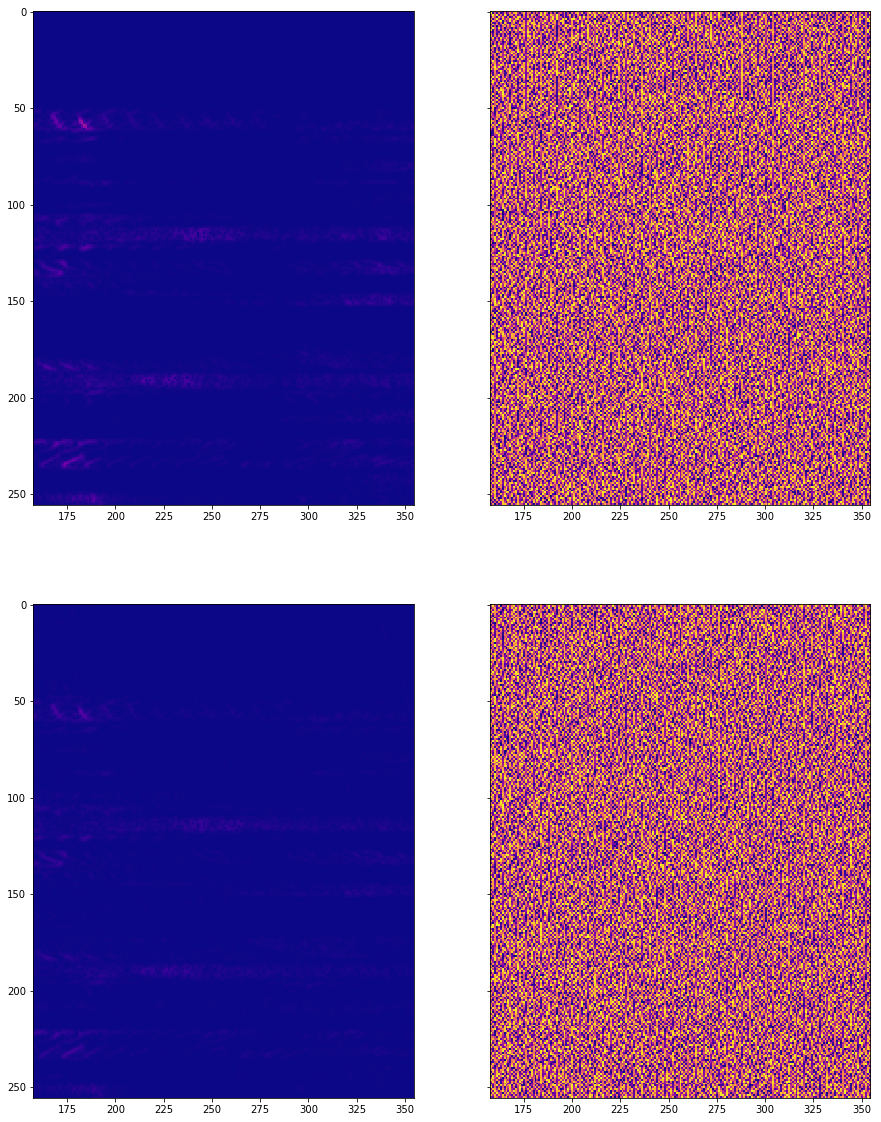

In [144]:
fig, ax = plt.subplots(2, 2, figsize=(15,20), sharey=True)
plt.plasma()
ax[0,0].imshow(mix_mag)
ax[0,1].imshow(mix_phase)
ax[1,0].imshow(voice_mag)
ax[1,1].imshow(voice_phase)


In [119]:
np.squeeze(val[0][:,:,0]).shape

(256, 513)